In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.helper_functions import load_dm
from utils.arguments import get_parser

from nets.wrapper import ContrastiveWrapper

from pytorch_lightning import Trainer

In [2]:
parser = get_parser()
args = parser.parse_args('''
--dataset UCI-HAR --batch_size 128 --window_size 25 --normalize --subjects_for_test 21 20 19 18 17 
--max_epochs 10 --lr 0.01 --training_dir training_clr --n_val_subjects 4 --reduce_imbalance
--encoder_architecture cnn_gap_ts --encoder_features 20 --cf 0.001 --label_mode 25 --mode clr3'''.split())

dm = load_dm(args)

Loaded dataset UCI-HAR with a total of 815614 observations for window size 25
Sampling 51607 (balanced) observations per epoch.
Using 626740 observations for training, 106617 for validation and 143333 observations for test


In [3]:
model = ContrastiveWrapper.load_from_checkpoint(checkpoint_path="_clr/clr3_UCI-HAR_21-20-19-18-17_4_25_1_bs128_lr0.001_l10_l20_cnn_gap_ts20_mlpNone_1_m25_decay0.01/version_0/checkpoints/epoch=7-step=3112-val_re=0.0000.ckpt")
model.eval()
print()

Input shape:  torch.Size([1, 6, 25])
Latent shape:  torch.Size([1, 80])



/home/mbikandi/miniconda3/envs/dev2/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv1d(input, weight, bias, self.stride,


In [4]:
labels = []
d = 3300
for i in range(0, d):
    labels.append(dm.ds_test[i]["label"].item())

In [5]:
tr = Trainer()
tr.test(datamodule=dm, model=model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 1120/1120 [00:06<00:00, 165.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_ap            0.42473703622817993
       test_auroc           0.9155766367912292
       test_fpr95           0.36666956543922424
        test_loss                   0.0
         test_th             1.751399278640747
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0,
  'test_fpr95': 0.36666956543922424,
  'test_th': 1.751399278640747,
  'test_auroc': 0.9155766367912292,
  'test_ap': 0.42473703622817993}]

In [6]:
normalized_rpr = torch.nn.functional.normalize(model.rpr)

In [7]:
diff = (normalized_rpr[:-model.window_size, :] - normalized_rpr[model.window_size:, :]).square().sum(-1) + 1e-8
dissimilarities = diff.sqrt()

In [8]:
cumsum_diss = torch.cumsum(dissimilarities, dim=-1)

In [9]:
dissimilarities.shape

torch.Size([143308])

In [10]:
dissimilarities_smooth = (cumsum_diss[25:] - cumsum_diss[:-25])/25

In [11]:
dissimilarities_smooth.shape

torch.Size([143283])

In [12]:
diff_diss_diss_smooth = dissimilarities_smooth - dissimilarities[25:]

In [13]:
kernel = 1/(1+np.power(np.arange(-9, 10), 2))

In [14]:
new_curve = torch.nn.functional.conv1d(dissimilarities.unsqueeze(0), torch.from_numpy(kernel).float().unsqueeze(0).unsqueeze(0)).squeeze()

In [15]:
new_curve.shape

torch.Size([143290])

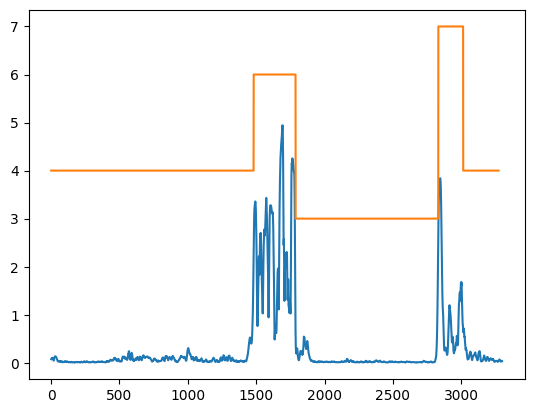

In [16]:
plt.plot(np.arange(d), new_curve[:d], np.arange(len(labels)-25), labels[25:])